## Javier Mombiela
## Carnet: 20067

### Laboratorio #8: Defensa de modelos contra ataques

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

In [2]:
path = './malimg_paper_dataset_imgs/'

In [3]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [4]:
familias.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [5]:
imgs, labels = next(familias)

In [6]:
imgs.shape

(9339, 64, 64, 3)

In [7]:
labels.shape

(9339, 25)

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

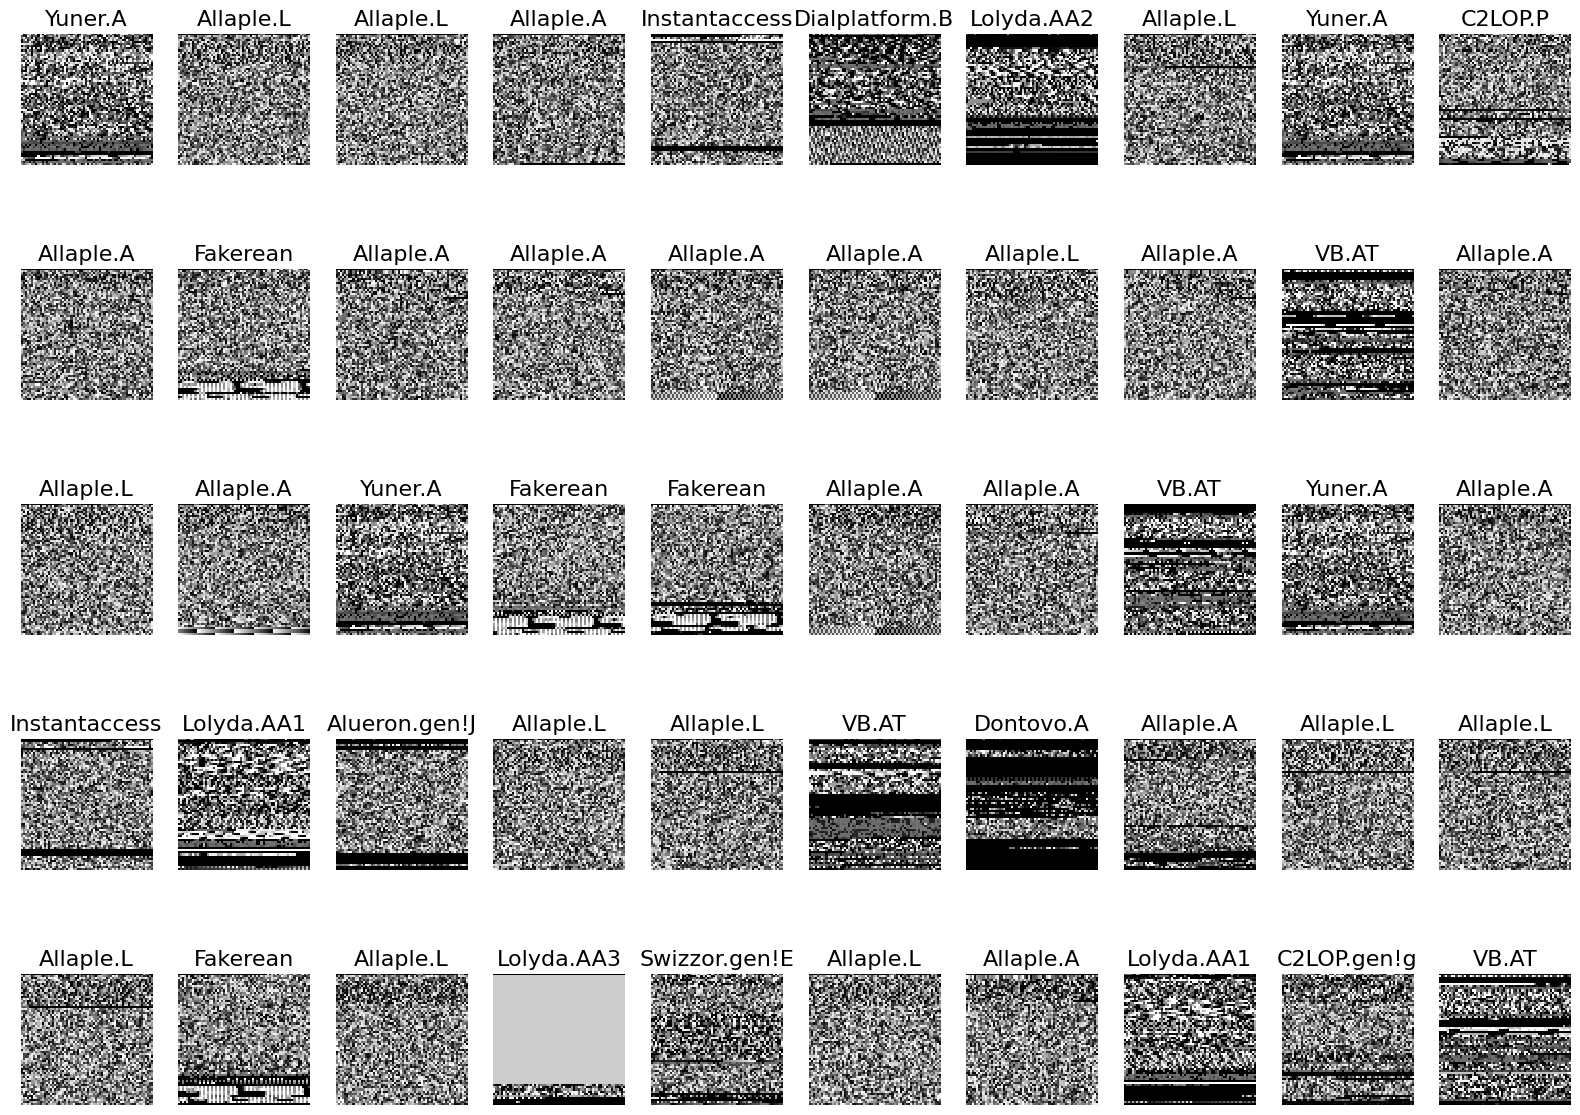

In [9]:
plots(imgs, titles = labels)

### Preprocesamiento

In [10]:
# Conteo de observaciones por familia
counts = {}
for familia in os.listdir(path):
    if os.path.isdir(os.path.join(path, familia)):
        num_observaciones = len(os.listdir(os.path.join(path, familia)))
        counts[familia] = num_observaciones

# Imprimir el conteo de observaciones por familia
for familia, num_observaciones in counts.items():
    print(f"Familia: {familia}, Observaciones: {num_observaciones}")

Familia: Adialer.C, Observaciones: 122
Familia: Agent.FYI, Observaciones: 116
Familia: Allaple.A, Observaciones: 2949
Familia: Allaple.L, Observaciones: 1591
Familia: Alueron.gen!J, Observaciones: 198
Familia: Autorun.K, Observaciones: 106
Familia: C2LOP.gen!g, Observaciones: 200
Familia: C2LOP.P, Observaciones: 146
Familia: Dialplatform.B, Observaciones: 177
Familia: Dontovo.A, Observaciones: 162
Familia: Fakerean, Observaciones: 381
Familia: Instantaccess, Observaciones: 431
Familia: Lolyda.AA1, Observaciones: 213
Familia: Lolyda.AA2, Observaciones: 184
Familia: Lolyda.AA3, Observaciones: 123
Familia: Lolyda.AT, Observaciones: 159
Familia: Malex.gen!J, Observaciones: 136
Familia: Obfuscator.AD, Observaciones: 142
Familia: Rbot!gen, Observaciones: 158
Familia: Skintrim.N, Observaciones: 80
Familia: Swizzor.gen!E, Observaciones: 128
Familia: Swizzor.gen!I, Observaciones: 132
Familia: VB.AT, Observaciones: 408
Familia: Wintrim.BX, Observaciones: 97
Familia: Yuner.A, Observaciones: 800


In [11]:
# Decidir el número mínimo de observaciones requeridas
min_obs = 100

# Filtrar las clases con pocas observaciones
familias_filtradas = [familia for familia, num_observaciones in counts.items() if num_observaciones >= min_obs]

# Imprimir las clases filtradas
print("\nFamilias con suficientes observaciones:")
for cls in familias_filtradas:
    print(cls)


Familias con suficientes observaciones:
Adialer.C
Agent.FYI
Allaple.A
Allaple.L
Alueron.gen!J
Autorun.K
C2LOP.gen!g
C2LOP.P
Dialplatform.B
Dontovo.A
Fakerean
Instantaccess
Lolyda.AA1
Lolyda.AA2
Lolyda.AA3
Lolyda.AT
Malex.gen!J
Obfuscator.AD
Rbot!gen
Swizzor.gen!E
Swizzor.gen!I
VB.AT
Yuner.A


In [12]:
nombres_clases_generador = list(familias.class_indices.keys())

# Obtener los índices de las imágenes correspondientes a las familias filtradas
indices_familias_filtradas = [np.where(np.argmax(labels, axis=1) == nombres_clases_generador.index(familia))[0] for familia in familias_filtradas]
indices_familias_filtradas = np.concatenate(indices_familias_filtradas, axis=0)

# Filtrar las imágenes y etiquetas
imgs_filtradas = imgs[indices_familias_filtradas]
labels_filtradas = labels[indices_familias_filtradas]

#### Division de datos

In [13]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(imgs_filtradas, labels_filtradas, test_size=0.3, random_state=42)

print("Dimensiones del conjunto de entrenamiento:")
print("Imágenes:", X_train.shape)
print("Etiquetas:", y_train.shape)

print("\nDimensiones del conjunto de prueba:")
print("Imágenes:", X_test.shape)
print("Etiquetas:", y_test.shape)

Dimensiones del conjunto de entrenamiento:
Imágenes: (6413, 64, 64, 3)
Etiquetas: (6413, 25)

Dimensiones del conjunto de prueba:
Imágenes: (2749, 64, 64, 3)
Etiquetas: (2749, 25)


#### Modelo Victima

In [14]:
def create_victim_model(input_shape):
    model = Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape),
        MaxPooling2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(units=128, activation="relu"),
        Dense(units=25, activation="softmax")  # 25 clases de malware
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [15]:
input_shape = (64, 64, 3)

# Crear el modelo
victim_model = create_victim_model(input_shape)

# Entrenar el modelo
history = victim_model.fit(
    x=X_train,
    y=y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.3
)

Epoch 1/10


c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4743 - loss: 56.9199 - val_accuracy: 0.8176 - val_loss: 0.6316
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8871 - loss: 0.3661 - val_accuracy: 0.8628 - val_loss: 0.5262
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9375 - loss: 0.1962 - val_accuracy: 0.8919 - val_loss: 0.4784
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9696 - loss: 0.0918 - val_accuracy: 0.8867 - val_loss: 0.6785
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9658 - loss: 0.1103 - val_accuracy: 0.8903 - val_loss: 0.5509
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9618 - loss: 0.1368 - val_accuracy: 0.8690 - val_loss: 0.7166
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9715 - loss: 0.1062 - val_accuracy: 0.8477 - val_loss: 0.8755
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9750 - loss: 0.1258 - val_accuracy: 0.88

In [16]:
test_loss, test_acc = victim_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9296 - loss: 0.4676
Test accuracy: 0.921425998210907


In [17]:
# Guardar el modelo
victim_model.save("modelo_victima.h5")

### Ataques contra el modelo victima


In [18]:
import tensorflow as tf
from art.attacks.extraction import CopycatCNN
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


#### Ataque de Evasión

El ataque de Gradiente Rápido (Fast Gradient Sign Method, FGSM) es una técnica de adversarial machine learning utilizada para generar imágenes adversarias de manera eficiente. La idea básica detrás del ataque FGSM es modificar ligeramente los píxeles de una imagen de entrada de manera que el modelo de clasificación cometa un error en su predicción, mientras que para un observador humano la imagen sigue siendo indistinguible de la original.

El proceso de generación de imágenes adversarias con FGSM es relativamente simple pero efectivo. Primero, se calcula el gradiente de la función de pérdida del modelo con respecto a los píxeles de la imagen de entrada. Luego, se modifica la imagen de entrada agregando un pequeño paso en la dirección del gradiente, multiplicado por un factor llamado epsilon (ε), que determina la magnitud del cambio realizado en los píxeles. En este caso, el valor de epsilon se establece en 2.1, lo que controla la magnitud de la perturbación aplicada a la imagen original. El signo del gradiente se utiliza para determinar si se debe aumentar o disminuir el valor de cada píxel para maximizar la pérdida del modelo.

En el código proporcionado, el valor de epsilon se establece en 2.1:
```python
attack_fgsm = FastGradientMethod(estimator=clasificador, eps=2.1)
```
Un valor más alto de epsilon resultará en una perturbación más grande en la imagen adversaria, lo que puede llevar a cambios más significativos en la clasificación del modelo. Sin embargo, un epsilon demasiado grande puede hacer que la imagen adversaria sea demasiado perceptible para un observador humano.

Es importante destacar que al evaluar el modelo original en imágenes adversarias generadas por FGSM, el accuracy original, que fue del 93%, disminuyó significativamente a un 49%. Esto ilustra el impacto del ataque en la capacidad del modelo para realizar predicciones precisas cuando se enfrenta a imágenes adversarias.

In [19]:
# Cargar el modelo víctima
vulnerable_model = tf.keras.models.load_model("modelo_victima.h5")

# Crear el clasificador ART
clasificador = TensorFlowV2Classifier(
    model=vulnerable_model, 
    nb_classes=25, 
    input_shape=(64, 64, 3), 
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam()
)

# Configurar el ataque de gradiente rápido
attack_fgsm = FastGradientMethod(estimator=clasificador, eps=2.1)

# Generar imágenes adversarias
test_images_adv = attack_fgsm.generate(x=X_test)

Prueba del ataque Fast Gradient Method contra el modelo víctima

In [20]:
# Evaluar el modelo en imágenes limpias
score_clean = vulnerable_model.evaluate(x=X_test, y=y_test)

# Evaluar el modelo en imágenes adversarias
score_adv = vulnerable_model.evaluate(x=test_images_adv, y=y_test)

# Comparar pérdidas en el conjunto de prueba
print(f"Clean test set loss: {score_clean[0]:.2f} vs adversarial test set loss: {score_adv[0]:.2f}")

# Comparar precisión en el conjunto de prueba
print(f"Clean test set accuracy: {score_clean[1]:.2f} vs adversarial test set accuracy: {score_adv[1]:.2f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9296 - loss: 0.4676
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4862 - loss: 6.8454
Clean test set loss: 0.51 vs adversarial test set loss: 6.89
Clean test set accuracy: 0.92 vs adversarial test set accuracy: 0.49


#### Ataque de Extracción

El ataque de extracción CopycatCNN es una técnica de adversarial machine learning que tiene como objetivo robar el conocimiento de un modelo de clasificación existente, también conocido como modelo víctima. En este caso, la implementación utiliza una red neuronal convolucional (CNN) para llevar a cabo el ataque.

En primer lugar, se selecciona un modelo de clasificación existente que se desea atacar. Este modelo se conoce como el modelo víctima y puede tener arquitectura CNN u otro tipo de modelo. Luego, se crea un nuevo modelo de clasificación, denominado modelo en blanco o modelo ladrón, que tiene una arquitectura similar pero con parámetros inicializados al azar. Este modelo se utilizará para robar el conocimiento del modelo víctima.

Se configura el ataque de extracción CopycatCNN con los parámetros adecuados, como el tamaño del lote de consultas (batch size), el número de épocas de entrenamiento, y el número máximo de muestras robadas. Utilizando el modelo en blanco como base, el ataque CopycatCNN realiza una serie de consultas al modelo víctima con ejemplos de datos de entrada. Luego, utiliza las respuestas del modelo víctima para entrenar el modelo en blanco, ajustando sus parámetros para que se comporte de manera similar al modelo víctima.

Una vez completada la extracción, el modelo en blanco se convierte en el modelo robado. Este modelo se puede evaluar utilizando un conjunto de datos de prueba para medir su precisión y compararlo con el modelo víctima original. En este caso, el modelo víctima tiene una precisión del 93%, mientras que el modelo robado alcanza una precisión del 86%. Esto resalta la efectividad del ataque CopycatCNN en la extracción del conocimiento del modelo víctima, aunque con una pérdida de precisión en el modelo robado.

In [21]:
# Crear el ataque de extracción CopycatCNN
attack_copycat = CopycatCNN(
    classifier=clasificador, # Clasificador de la víctima definido anteriormente
    batch_size_query=1,
    nb_epochs=10,
    nb_stolen=1000
)

In [22]:
#Definimos un nuevo modelo
def create_blank_model():
    # Defining the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(25, activation='softmax')
    ])

    # Compiling the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Returning the model
    return model

In [23]:
# Crear el modelo robado
stolen_model = TensorFlowV2Classifier(
    model=create_blank_model(),
    nb_classes=25,
    input_shape=(64, 64, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam() 
)

# Extraer el modelo robado
stolen_classifier = attack_copycat.extract(
    x=X_test, 
    y=None, 
    thieved_classifier=stolen_model
)

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Prueba del ataque CopycatCNN contra el modelo víctima

In [24]:
# Evaluar el modelo original en el conjunto de prueba
score_original = clasificador._model.evaluate(
    x=X_test, 
    y=y_test
    )

# Evaluar el modelo robado en el conjunto de prueba
score_stolen = stolen_classifier._model.evaluate(
    x=X_test, 
    y=y_test
    )

# Comparar pérdidas en el conjunto de prueba
print(f"Original test loss: {score_original[0]:.2f} " 
      f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparar precisión en el conjunto de prueba
print(f"Original test accuracy: {score_original[1]:.2f} " 
      f"vs stolen test accuracy: {score_stolen[1]:.2f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9296 - loss: 0.4676
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8596 - loss: 6.1193
Original test loss: 0.51 vs stolen test loss: 6.25
Original test accuracy: 0.92 vs stolen test accuracy: 0.86


### Defensa contra Ataques

In [25]:
from art.defences.trainer import AdversarialTrainer

#### Defensa contra Ataques de Evasión: Adversarial Training

El entrenamiento adversarial es una técnica de defensa eficaz contra los ataques de evasión, como el Fast Gradient Sign Method (FGSM). Esta técnica implica entrenar al modelo utilizando tanto datos originales como datos adversariales generados por el mismo ataque, en este caso, FGSM con un epsilon (ε) de 2.1. Al exponer al modelo a ejemplos adversariales durante el entrenamiento, este aprende a reconocer y manejar perturbaciones, mejorando su robustez ante ataques. La elección de este método se basa en su capacidad para fortalecer al modelo de manera directa contra las técnicas específicas de evasión utilizadas, manteniendo así su rendimiento en condiciones adversas.

En el experimento, se generaron imágenes adversariales con el mismo epsilon (ε = 2.1) y se utilizó el ataque FGSM para evaluar el modelo. Los resultados mostraron que el modelo robustecido mantuvo una precisión del 93% tanto en datos limpios como adversariales, con pérdidas de 0.38 y 0.39, respectivamente. En comparación, el modelo sin defensa tuvo una precisión de 93% en datos limpios que cayó drásticamente a 49% en datos adversariales, con pérdidas de 0.51 y 6.89. Estos resultados demuestran que el entrenamiento adversarial mejora significativamente la capacidad del modelo para resistir ataques de evasión, manteniendo su desempeño casi intacto incluso en presencia de perturbaciones adversariales.

In [26]:
# Crear el modelo víctima
victim_model_adv = create_victim_model(input_shape)

# Generar ejemplos adversariales para el entrenamiento
adv_train_images = attack_fgsm.generate(x=X_train) # Este ataque FGSM es el mismo que se usó anteriormente (mismos epsilon)

# Concatenar los ejemplos adversariales al conjunto de entrenamiento
X_train_adv = np.concatenate((X_train, adv_train_images))
y_train_adv = np.concatenate((y_train, y_train))

# Entrear el modelo víctima con ejemplos adversariales
victim_model_adv.fit(
    x=X_train_adv,
    y=y_train_adv,
    epochs=10,
    batch_size=32,
    validation_split=0.3
)

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5789 - loss: 28.7647 - val_accuracy: 0.9025 - val_loss: 0.3174
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9168 - loss: 0.2690 - val_accuracy: 0.9654 - val_loss: 0.1132
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9752 - loss: 0.0895 - val_accuracy: 0.9343 - val_loss: 0.1865
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9540 - loss: 0.1491 - val_accuracy: 0.9660 - val_loss: 0.1161
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9775 - loss: 0.0774 - val_accuracy: 0.9732 - val_loss: 0.1170
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9690 - loss: 0.1052 - val_accuracy: 0.9857 - val_loss: 0.0520
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9804 - loss: 0.0664 - val_accuracy: 0.9836 - val_loss: 0.0554
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9867 - loss: 0.0418 -

Prueba de adversarial training contra el ataque FGM

In [27]:
# Evaluar el modelo robustecido
score_clean_adv = victim_model_adv.evaluate(x=X_test, y=y_test)

# Generar ejemplos adversariales para el conjunto de prueba
test_images_adv = attack_fgsm.generate(x=X_test)

# Evaluar el modelo robustecido en ejemplos adversariales
score_adv_adv = victim_model_adv.evaluate(x=test_images_adv, y=y_test)

# Comparar pérdidas en el conjunto de prueba
print(f"Clean test set loss: {score_clean_adv[0]:.2f} vs adversarial test set loss: {score_adv_adv[0]:.2f}")

# Comparar precisión en el conjunto de prueba
print(f"Clean test set accuracy: {score_clean_adv[1]:.2f} vs adversarial test set accuracy: {score_adv_adv[1]:.2f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9375 - loss: 0.3446
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9377 - loss: 0.3515
Clean test set loss: 0.38 vs adversarial test set loss: 0.39
Clean test set accuracy: 0.93 vs adversarial test set accuracy: 0.93


#### Defensa contra Ataques de Extracción: Inserción de ruido

La técnica de defensa implementada contra el ataque de extracción es la inserción de ruido en las predicciones del modelo. Esta estrategia añade pequeñas perturbaciones aleatorias a las salidas del modelo original, dificultando que un atacante pueda entrenar un modelo robado que imite con precisión el comportamiento del modelo original. La elección de esta técnica se basa en su capacidad para proteger la información del modelo mientras mantiene un rendimiento aceptable en el conjunto de datos limpio. En este contexto, la desviación estándar del ruido, establecida en 0.6, determina la magnitud de las perturbaciones agregadas a las predicciones del modelo, contribuyendo así a la robustez y eficacia de la defensa.

Con esta defensa, el modelo original mantuvo una pérdida de 0.51 y una precisión del 92% en el conjunto de datos limpio, mientras que el modelo robado que utilizó las predicciones ruidosas mostró una pérdida de 2.70 y una precisión de 33%. Estos resultados indican que la defensa ha sido efectiva, ya que el modelo robado presenta una precisión significativamente menor que el modelo original.

Sin la defensa, el modelo original y el modelo robado se evaluaron con una pérdida de 0.51 y una precisión del 92% para el original, y una pérdida de 6.25 y una precisión del 86% para el modelo robado sin ruido. Esto demuestra que, sin la defensa, el atacante pudo extraer un modelo con una precisión relativamente alta, cercana a la del modelo original. La comparación destaca la efectividad de la defensa basada en la inserción de ruido, ya que el modelo robado con ruido muestra una precisión mucho más baja, lo que significa que la defensa ha logrado su objetivo de hacer que el modelo robado sea menos útil para el atacante.

In [31]:
# Cargar el modelo víctima
victim_model = tf.keras.models.load_model("modelo_victima.h5")

# Crear el clasificador ART
class NoisyClassifier(TensorFlowV2Classifier):
    def predict(self, x, batch_size=128, **kwargs):
        predictions = super().predict(x, batch_size=batch_size, **kwargs)
        noise = np.random.normal(loc=0, scale=0.6, size=predictions.shape)
        return predictions + noise

In [32]:
# Limitación de consultas 
# Agregar ruido a las predicciones

# Crear el clasificador con ruido
noisy_clasificador = NoisyClassifier(
    model=victim_model,
    nb_classes=25,
    input_shape=(64, 64, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo con ruido en las predicciones
noisy_attack_copycat = CopycatCNN(
    classifier=noisy_clasificador,
    batch_size_query=1,
    nb_epochs=10,
    nb_stolen=1000
)

# Extraer el modelo robado
noisy_stolen_classifier = noisy_attack_copycat.extract(
    x=X_test, 
    y=None, 
    thieved_classifier=stolen_model
)

Prueba de inserción de ruido contra el ataque CopycatCNN

In [33]:
# Evaluar el modelo original en el conjunto de prueba
score_original_noisy = clasificador._model.evaluate(x=X_test, y=y_test)

# Evaluar el modelo robado en el conjunto de prueba
score_noisy_stolen = noisy_stolen_classifier._model.evaluate(x=X_test, y=y_test)

# Comparar pérdidas en el conjunto de prueba
print(f"Original test loss: {score_original_noisy[0]:.2f} vs noisy stolen test loss: {score_noisy_stolen[0]:.2f}")

# Comparar precisión en el conjunto de prueba
print(f"Original test accuracy: {score_original_noisy[1]:.2f} vs noisy stolen test accuracy: {score_noisy_stolen[1]:.2f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9296 - loss: 0.4676
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3257 - loss: 2.6810
Original test loss: 0.51 vs noisy stolen test loss: 2.70
Original test accuracy: 0.92 vs noisy stolen test accuracy: 0.33
